Centro de Estudos e Sistemas Avançados do Recife

Pós-graduação em Engenharia e Análise de Dados

Disciplina de RNA e Deep Learning

Professor: Silvan Ferreira da Silva Junior 
 
Grupo:
* Anísio Pereira Batista Filho (apbf@cesar.school)
* Carlos Cezar Lopes de Mendonça (cclm@cesar.school)
* Rodolpho Victor França Valsconcelos (rvfv@cesar.school)

## Exercício
Um dataset sintético contendo alguns exemplos de diferentes formas básicas é criado. Em seguida, crie um dataset e um modelo convolucional que classifique o formato na imagem.

In [1]:
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Parâmetros
image_size = 64
num_examples = 2000
num_classes = 5
output_file = "data/synthetic.csv"

In [3]:
# Função para gerar uma imagem de uma determinada classe
def generate_image(label):
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)
    if label == 0:
        # Classe 0: Círculos
        center = (np.random.randint(10, image_size-10), np.random.randint(10, image_size-10))
        radius = np.random.randint(5, 10)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.circle(image, center, radius, color, -1)
    elif label == 1:
        # Classe 1: Triângulos equiláteros
        side_length = np.random.randint(10, 20)
        height = int(np.sqrt(3)/2 * side_length)
        center = (np.random.randint(side_length//2, image_size-side_length//2),
                  np.random.randint(height//2, image_size-height//2))
        pts = np.array([[center[0], center[1] - 2*height//3],
                        [center[0] - side_length//2, center[1] + height//3],
                        [center[0] + side_length//2, center[1] + height//3]], np.int32)
        pts = pts.reshape((-1, 1, 2))
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.fillPoly(image, [pts], color)
    elif label == 2:
        # Classe 2: Linhas Horizontais
        y = np.random.randint(5, image_size-5)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        thickness = np.random.randint(1, 3)
        cv2.line(image, (0, y), (image_size, y), color, thickness)
    elif label == 3:
        # Classe 3: Quadrados
        top_left = (np.random.randint(10, image_size-10), np.random.randint(10, image_size-10))
        size = np.random.randint(5, 10)
        bottom_right = (top_left[0] + size, top_left[1] + size)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        cv2.rectangle(image, top_left, bottom_right, color, -1)
    elif label == 4:
        # Classe 4: Linhas Verticais
        x = np.random.randint(5, image_size-5)
        color = (np.random.randint(256), np.random.randint(256), np.random.randint(256))
        thickness = np.random.randint(1, 3)
        cv2.line(image, (x, 0), (x, image_size), color, thickness)

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

In [4]:
def show_image(image):
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

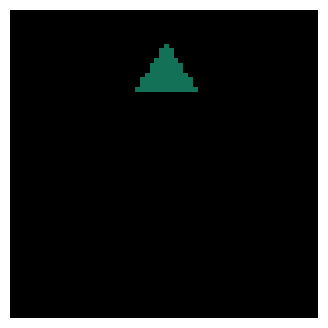

In [5]:
show_image(generate_image(1))

In [6]:
data = []
labels = []
for _ in tqdm(range(num_examples)):
    label = np.random.randint(0, num_classes)
    image = generate_image(label).flatten()
    data.append(np.concatenate(([label], image)))
    labels.append(label)

data = np.array(data)

# Salvando em CSV
df = pd.DataFrame(data)
df.to_csv(output_file, index=False, header=False)

print(f"Dataset salvo em {output_file}")

100%|██████████| 2000/2000 [00:00<00:00, 3181.62it/s]


Dataset salvo em data/synthetic.csv


## Agora é com você!

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

In [8]:
# Definição da classe SyntheticCSVLoader para carregar o dataset a partir de um arquivo CSV. Baseie-se no MNISTDataset do notebook "04 - Basic CNNs.ipynb"
class SyntheticCSVLoader(Dataset):
    def __init__(self, csv_file, image_size=64, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]

        # As demais colunas são os pixels da imagem (64x64x3)
        image = self.data.iloc[idx, 1:].values.astype(np.uint8).reshape(self.image_size, self.image_size, 3)

        # Converte a imagem para tensor e ajusta os eixos para o formato (C, H, W)
        image = torch.tensor(image).permute(2, 0, 1)

        if self.transform:
            image = self.transform(image)

        return image, label

In [9]:
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

synthetic_dataset = SyntheticCSVLoader(
    csv_file="data/synthetic.csv",
    transform=transform
)

In [10]:
image, label = synthetic_dataset[0]

In [11]:
# Dividindo o dataset em conjuntos de treino e teste
trainset = Subset(synthetic_dataset, range(1800))
valset = Subset(synthetic_dataset, range(1800, 2000))

In [12]:
# Criando DataLoaders para os subsets
train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
val_loader = DataLoader(valset, batch_size=32, shuffle=True)

In [13]:
images, labels = next(iter(valset))

In [14]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    ax1.plot(history['train_losses'], label='Train')
    ax1.plot(history['val_losses'], label='Validation')
    ax1.set_title('Loss')
    ax1.legend()

    ax2.plot(history['train_accuracies'], label='Train')
    ax2.plot(history['val_accuracies'], label='Validation')
    ax2.set_title('Accuracy')
    ax2.legend()

    plt.show()


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [15]:
class CNN(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 12, 5)
        self.conv2 = nn.Conv2d(12, 24, 5)
        self.conv3 = nn.Conv2d(24, 32, 5)
        self.fc1 = nn.Linear(32 * 4 * 4, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)

        x = x.view(-1, 32 * 4 * 4)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)

        return x


model = CNN()

images, labels = next(iter(val_loader))

model(images).shape

torch.Size([32, 5])

In [16]:
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [17]:
# Treinamento
history = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15)

100%|██████████| 57/57 [00:23<00:00,  2.38it/s]


Epoch 1, Train Loss: 1.515, Train Accuracy: 34.28%
Epoch 1, Val Loss: 1.212, Val Accuracy: 55.00%


100%|██████████| 57/57 [00:25<00:00,  2.24it/s]


Epoch 2, Train Loss: 0.951, Train Accuracy: 61.44%
Epoch 2, Val Loss: 0.626, Val Accuracy: 73.00%


100%|██████████| 57/57 [00:23<00:00,  2.47it/s]


Epoch 3, Train Loss: 0.635, Train Accuracy: 71.67%
Epoch 3, Val Loss: 0.457, Val Accuracy: 83.50%


100%|██████████| 57/57 [00:22<00:00,  2.52it/s]


Epoch 4, Train Loss: 0.450, Train Accuracy: 81.11%
Epoch 4, Val Loss: 0.300, Val Accuracy: 90.00%


100%|██████████| 57/57 [00:23<00:00,  2.39it/s]


Epoch 5, Train Loss: 0.258, Train Accuracy: 91.22%
Epoch 5, Val Loss: 0.180, Val Accuracy: 95.00%


100%|██████████| 57/57 [00:19<00:00,  2.98it/s]


Epoch 6, Train Loss: 0.198, Train Accuracy: 93.22%
Epoch 6, Val Loss: 0.148, Val Accuracy: 96.50%


100%|██████████| 57/57 [00:21<00:00,  2.70it/s]


Epoch 7, Train Loss: 0.118, Train Accuracy: 96.22%
Epoch 7, Val Loss: 0.084, Val Accuracy: 98.50%


100%|██████████| 57/57 [00:20<00:00,  2.75it/s]


Epoch 8, Train Loss: 0.076, Train Accuracy: 97.83%
Epoch 8, Val Loss: 0.066, Val Accuracy: 98.00%


100%|██████████| 57/57 [00:34<00:00,  1.63it/s]


Epoch 9, Train Loss: 0.050, Train Accuracy: 98.22%
Epoch 9, Val Loss: 0.100, Val Accuracy: 98.50%


100%|██████████| 57/57 [00:23<00:00,  2.45it/s]


Epoch 10, Train Loss: 0.036, Train Accuracy: 99.06%
Epoch 10, Val Loss: 0.049, Val Accuracy: 99.00%


100%|██████████| 57/57 [00:26<00:00,  2.18it/s]


Epoch 11, Train Loss: 0.029, Train Accuracy: 99.22%
Epoch 11, Val Loss: 0.053, Val Accuracy: 98.00%


100%|██████████| 57/57 [00:30<00:00,  1.86it/s]


Epoch 12, Train Loss: 0.050, Train Accuracy: 98.72%
Epoch 12, Val Loss: 0.062, Val Accuracy: 98.00%


100%|██████████| 57/57 [00:25<00:00,  2.25it/s]


Epoch 13, Train Loss: 0.064, Train Accuracy: 97.83%
Epoch 13, Val Loss: 0.103, Val Accuracy: 97.00%


100%|██████████| 57/57 [00:26<00:00,  2.16it/s]


Epoch 14, Train Loss: 0.234, Train Accuracy: 93.50%
Epoch 14, Val Loss: 0.132, Val Accuracy: 97.50%


100%|██████████| 57/57 [00:26<00:00,  2.15it/s]


Epoch 15, Train Loss: 0.109, Train Accuracy: 95.89%
Epoch 15, Val Loss: 0.070, Val Accuracy: 98.00%
Treinamento concluído


In [18]:
# Teste
test_model(model, val_loader)

Acurácia da rede na base de teste: 98.00%


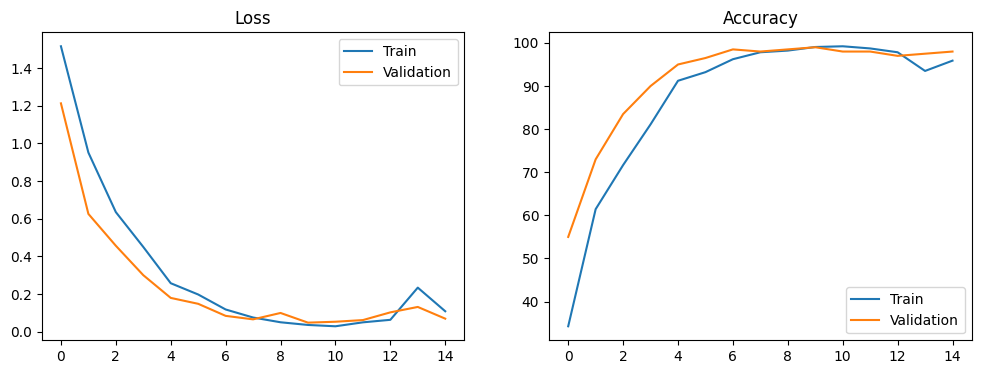

In [19]:
plot_history(history)